<a href="https://colab.research.google.com/github/GermanOmar/LaserVWC/blob/master/LaserWelding3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanical vibration effect over the microhardness of AISI A36 steel in a lap configuration joints by laser welding


<a href="https://ibb.co/VH5s6tP"><img src="https://i.ibb.co/PT0dkNf/LaserVWC.png" WIDTH="420" HEIGHT="300"  border="0"></a>

 Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

 Upload database:

In [2]:
!git clone https://github.com/GermanOmar/LaserVWC

Cloning into 'LaserVWC'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [10]:
#Experimental data
data = pd.read_table('dataset.txt') 
data.describe()


,Amplitude,Frequency,Position,HV
count,120.000000,120.000000,120.000000,120.000000
mean,0.384000,519.003500,2.500000,166.248333
std,0.131023,378.479946,1.714986,10.313758
min,0.200000,0.000000,0.000000,146.070000
25%,0.280000,210.082500,1.000000,157.500000
50%,0.400000,510.885000,2.500000,167.105000
75%,0.480000,831.985000,4.000000,174.162500
max,0.560000,1034.510000,5.000000,186.950000


<a href="https://ibb.co/cgFcLwg"><img src="https://i.ibb.co/JB7RQqB/Contour-Plot.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

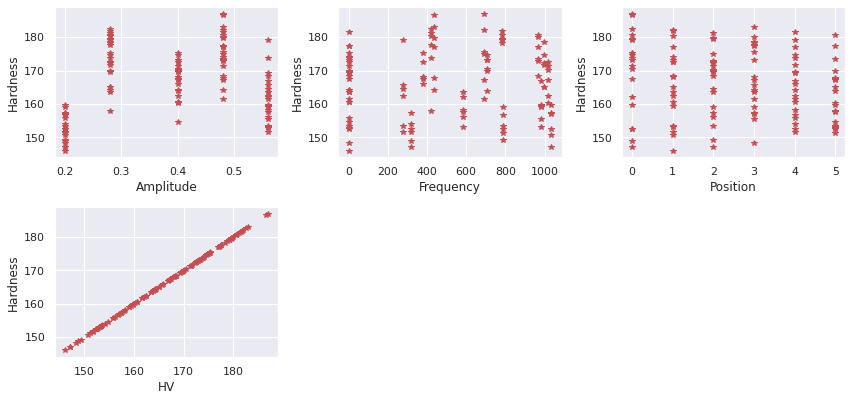

In [12]:
fields = [ 'Amplitude',  'Frequency', 'Position', 'HV']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['HV'], 'r*')
  plt.xlabel(field)
  plt.ylabel('Hardness')

plt.tight_layout()

X=data[[ 'Amplitude', 'Frequency', 'Position']]
Y=data['HV'][:,None]


#fig.tight_layout()

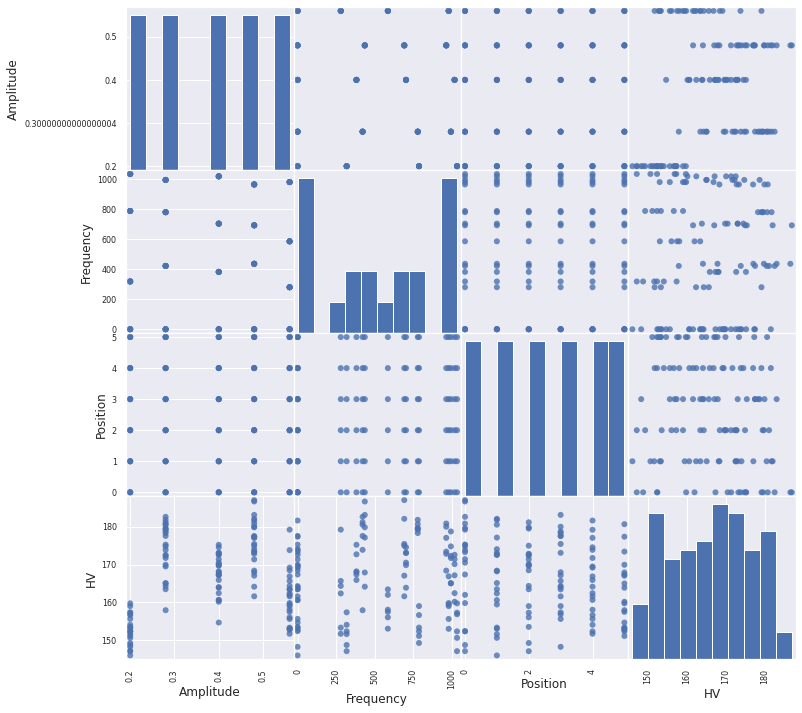

In [13]:
from pandas.plotting import scatter_matrix

#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))

import warnings
warnings.filterwarnings("ignore")

**Split**


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 96  test samples: 24


 Normalice

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)

#Results:

###GBR 

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 45.75096107740794

R2:  0.45678599884879545
RMSE:  6.763945673747531
MAE:  5.52540662964408
IM:  8.750780590974122



### GPs

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=5, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 1.6689506045064797e-08
MSE test: 47.14963199232047
MSE train < MSE test? True

R2_train:  0.9999999998480817
R2_test:  0.44017918653073396

R2:  0.44017918653073396
RMSE:  6.8665589629974395
MAE:  5.8376525547388844
IM:  9.03001764590542



### RFR

-----------------------------
MSE test: 21.048717868666028

R2:  0.7500826652975586
RMSE:  4.587888170898025
MAE:  3.7899983333334197
IM:  5.956111475578752



Text(0.5, 1.0, 'Random forest')

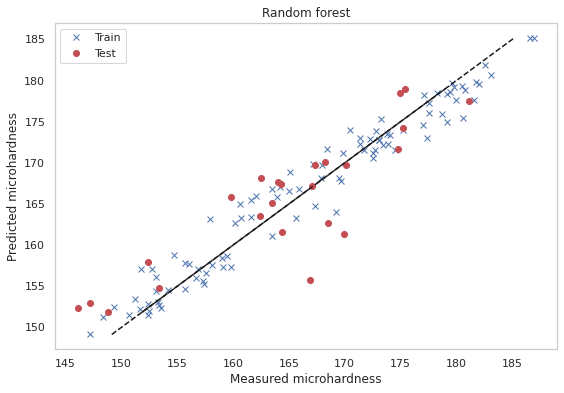

In [32]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_star_train = RFR.predict(X_train)
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted microhardness')
plt.xlabel('Measured microhardness')
plt.title("Random forest")

### XGB

In [20]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=2000, max_depth=20)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [21]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [22]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.6491989364044537


In [23]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 29.54541998634116

R2:  0.6491989364044537
RMSE:  5.435569886069092
MAE:  4.5208767191569015
IM:  7.078616226521664



### AdaBoost

 AdaBoost -
------------------
MSE test: 24.773905585591624

R2:  0.7058524660384282
RMSE:  4.977339207407068
MAE:  4.274680716207878
IM:  6.567596484471833



Text(0.5, 1.0, 'Adaboost')

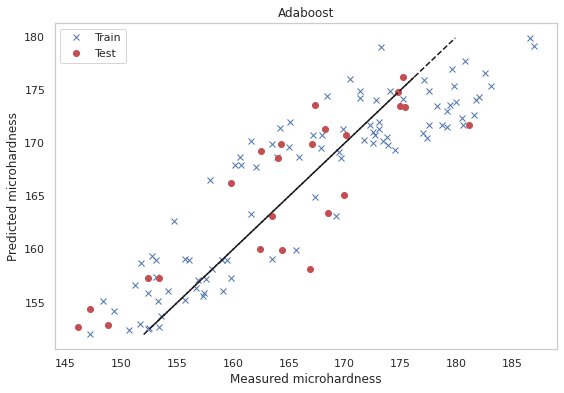

In [51]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='exponential',
                  n_estimators=10000, random_state=42)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_star_train = Ada.predict(X_train)
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted microhardness')
plt.xlabel('Measured microhardness')
plt.title("Adaboost")

In [49]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = Ada
n_estimators = [100, 1000, 10000]
learning_rate = [1, 0.1, 0.01, 1e-3]
loss = ["linear", "square", "exponential"]


grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, loss=loss )

In [50]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.71
AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='exponential',
                  n_estimators=10000, random_state=42)


### MLP

In [37]:
from sklearn.neural_network import MLPRegressor

#MLP = MLPRegressor(hidden_layer_sizes=8,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=42, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)
MLP = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=10, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.5582153133010206
RMSE:  5.106562908283459
MAE:  5.403914503068985
IM:  7.448117238748155



SVR

In [69]:
from sklearn.svm import SVR
SVM=SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.01, coef0=1)

#START TRAINING
SVM.fit(X_train,y_train)
#PREDICTION
y_pred=SVM.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


R2:  0.14918208591078164
RMSE:  4.977339207407068
MAE:  7.336609037649794
IM:  8.90638135719841



# Comparisson

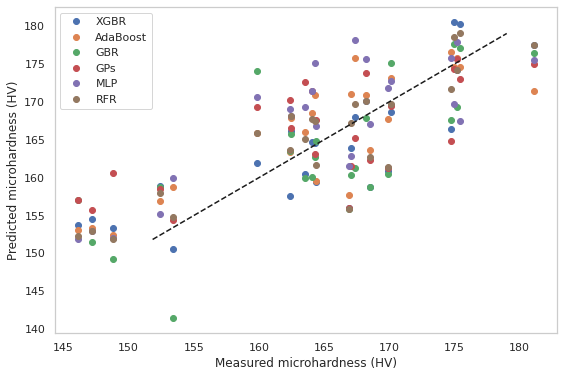

In [42]:
models = [xgbr, Ada, GBR,  GP, MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.legend()

# CROSS-VALIDATION

In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr, Ada, GBR,  GP,  MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.5022 | 49.5427 | 5.8791 | 9.1845 
       AdaBoost | 0.5845 | 40.2443 | 4.9800 | 8.0757 
            GBR | 0.3252 | 68.6628 | 7.0291 | 10.8870 
            GPs | 0.0494 | 109.9207 | 8.7621 | 13.6967 
            MLP | 0.3006 | 67.4512 | 6.6286 | 10.5773 
            RFR | 0.6060 | 38.4440 | 5.0738 | 8.0214 
--------------------------------------------------------------


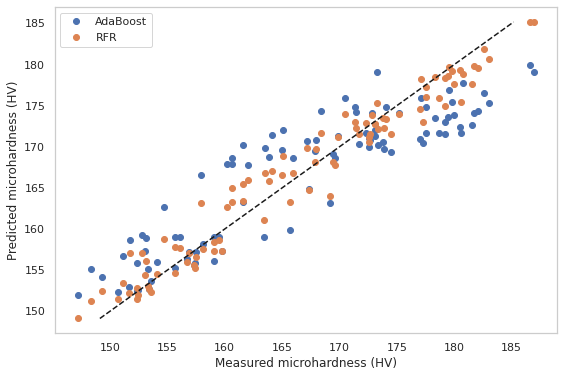

In [55]:
models = [Ada,  RFR ]
labels = [ 'AdaBoost','RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_train)
  plt.plot(y_train, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.legend()

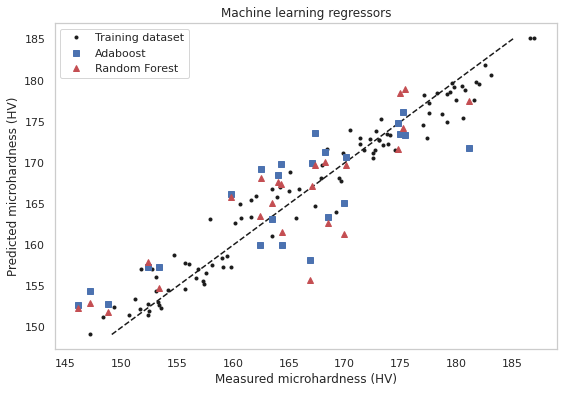

In [68]:
import seaborn as sns
sns.set()

y1=Ada.predict(X_test)
y2=RFR.predict(X_test)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'k.', label = 'Training dataset')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
#plt.plot(y_test, y1, 's', label = 'Adaboost',color='orange')
plt.plot(y_test, y1, 'bs', label = 'Adaboost')
plt.plot(y_test, y2, 'r^', label = 'Random Forest')

plt.legend()
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.title("Machine learning regressors")
print()

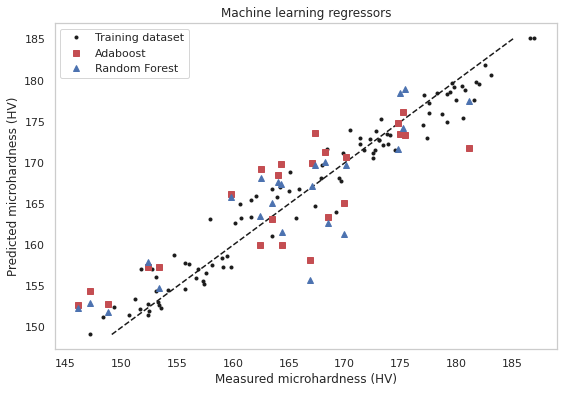

In [62]:
import seaborn as sns
sns.set()

y1=Ada.predict(X_test)
y2=RFR.predict(X_test)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'k.', label = 'Training dataset')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y1, 'rs', label = 'Adaboost')
plt.plot(y_test, y2, 'b^', label = 'Random Forest')

plt.legend()
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.title("Machine learning regressors")
print()